# IMPORTS

## Instalations

Installing libraries to google colab.

In [1]:
%pip install inflection
%pip install tabulate
%pip install sklearn
%pip install boruta
%pip install xgboost
%pip install json

     |████████████████████████████████| 61kB 2.9MB/s 
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


## Libraries

Libraries used in the project.

In [119]:
# google colab basic
from google.colab import drive

# stetic libraries
import warnings
from tabulate import tabulate
from IPython.core.display import HTML
from IPython.display import Image

# data manipulation libraries
import math
import datetime
import pandas as pd

# data analysis libraries
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

# data preparation
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# machine learning modeling
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# error traduction
from sklearn.metrics import mean_absolute_error, mean_squared_error

# deployment
import requests
import json
import pickle
from scipy import stats as ss
import inflection
from flask import Flask

warnings.filterwarnings('ignore')

Connecting drive to google colab

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


# 0.1. Helper Functions

Function to adjuste the screen.

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()

In [5]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


Manual function to cross validation.

In [6]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
  mae_list = []
  mape_list = []
  rmse_list = []
  for k in reversed(range(1, kfold+1)):
    if verbose:
        print('\nKFold Number: {}'.format(k))

    #start and end date for validation
    validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
    validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

    # filtering dataset
    training = x_training[x_training['date'] < validation_start_date]
    validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

    # training and validation dataset
    #validation
    xtraining = training.drop(['date', 'sales'], axis=1)
    ytraining = training['sales']

    #validation
    xvalidation = validation.drop(['date', 'sales'], axis=1)
    yvalidation = validation['sales']

    # model
    m = model.fit(xtraining, ytraining)

    # prediction
    yhat = m.predict(xvalidation)

    # performance
    m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

    # store performance of each kfold iteration
    mae_list.append(m_result['MAE'])
    mape_list.append(m_result['MAPE'])
    rmse_list.append(m_result['RMSE'])
    
  return pd.DataFrame({'Model Name': model_name,
          'MAE CV':str(np.round(np.mean(mae_list), 2)) + ' +/- ' + str(np.round(np.std(mae_list), 2)),
          'MAPE CV':str(np.round(np.mean(mape_list), 2)) + ' +/- ' + str(np.round(np.std(mape_list), 2)),
          'RMSE CV':str(np.round(np.mean(rmse_list), 2)) + ' +/- ' + str(np.round(np.std(rmse_list), 2))}, index=[0])

Functions to calculate the cramer_v (statistic analysis of cattegorical attributes) and mean percentage error.

In [7]:
def cramer_v(x, y): 
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat)/y)

Functions to calculate mean absolute percentage erro and to organizate the calculated errors from the model.

In [8]:
def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat)/y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE': mape,
                         'RMSE': rmse}, index=[0])

# 0.2. Loading data

Loading initial and after saved data.

## 0.2.1. Initial Data

In [9]:
df_sales_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

## 0.2.2.Fast Data

In [10]:
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'rb'))
yhat_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/yhat_xgb_tuned.pkl', 'rb'))
xgb_result_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/xgb_result_tuned.pkl', 'rb'))

In [11]:
# tabela com regressões depois do Cross Validation

modelling_result_cv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/results/general_cv.csv")

In [12]:
# Linear Regression Cross Validation

lr_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/lr_cv')

In [13]:
lrr_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/lrr_cv')

In [14]:
# Random Forest Cross Validation

rf_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/rf_cv.csv')

In [15]:
# XGBoost Cross Validation

model_xgb_result_cv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/results/xgb_cv.csv')

# 1.0. Descrição dos Dados

## 1.1. Rename Columns

In [16]:
df1 = df_raw.copy()

Passing the columns to snakecase

In [17]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore( x )

cols_new = list(map( snakecase, cols_old))

# rename
df1.columns = cols_new

## 1.2. Data Dimensions

Checking data dimensions

In [18]:
print('Number of Rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

Checking data types and changin date to datetime

In [19]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [20]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [25]:
#competition_distance = filling NA rows from the competition distance with one non-competitive number to represent the out of the competition.
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 
                                  if math.isnan(x) else x)

#competition_open_since_month = filling NA rows with month from the date column considering that the stories started they competition on this date.
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                else x['competition_open_since_month'], axis=1)


#competition_open_since_year = filling NA rows with year from the date column considering that the stories started they competition on this date.
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                               else x['competition_open_since_year'], axis=1)

                              
#promo2_since_week = filling NA rows with  from the date column considering that the stories started they competition on this date.
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                     else x['promo2_since_week'], axis=1)

#promo2_since_year = filling NA rows with  from the date column considering that the stories started they competition on this date.  
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                     else x['promo2_since_year'], axis=1)

#promo_interval = filling NA rows with 0 inplace.
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['promo_interval'].fillna(0, inplace=True)

#month_map = creating month_map column to indicate the month.
df1['month_map'] = df1['date'].dt.month.map(month_map)

#creating is_promo column to indicate if the storage is in promo or no.
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [26]:
df1.sample(5).T

,411269,562104,516719,234610,291435
store,620,930,145,461,986
day_of_week,6,4,2,5,1
date,2014-06-28 00:00:00,2014-02-13 00:00:00,2014-03-25 00:00:00,2015-01-02 00:00:00,2014-11-03 00:00:00
sales,9065,4962,0,5775,8307
customers,832,872,0,540,929
open,1,1,0,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,1,0
store_type,d,a,a,d,a


In [27]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Types

In [28]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [29]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [30]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

Separing columns to analytics.

In [31]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

Starting descriptive statistical analytics.

In [33]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
                                       
# concatenate                                     
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Checking column with the greater std

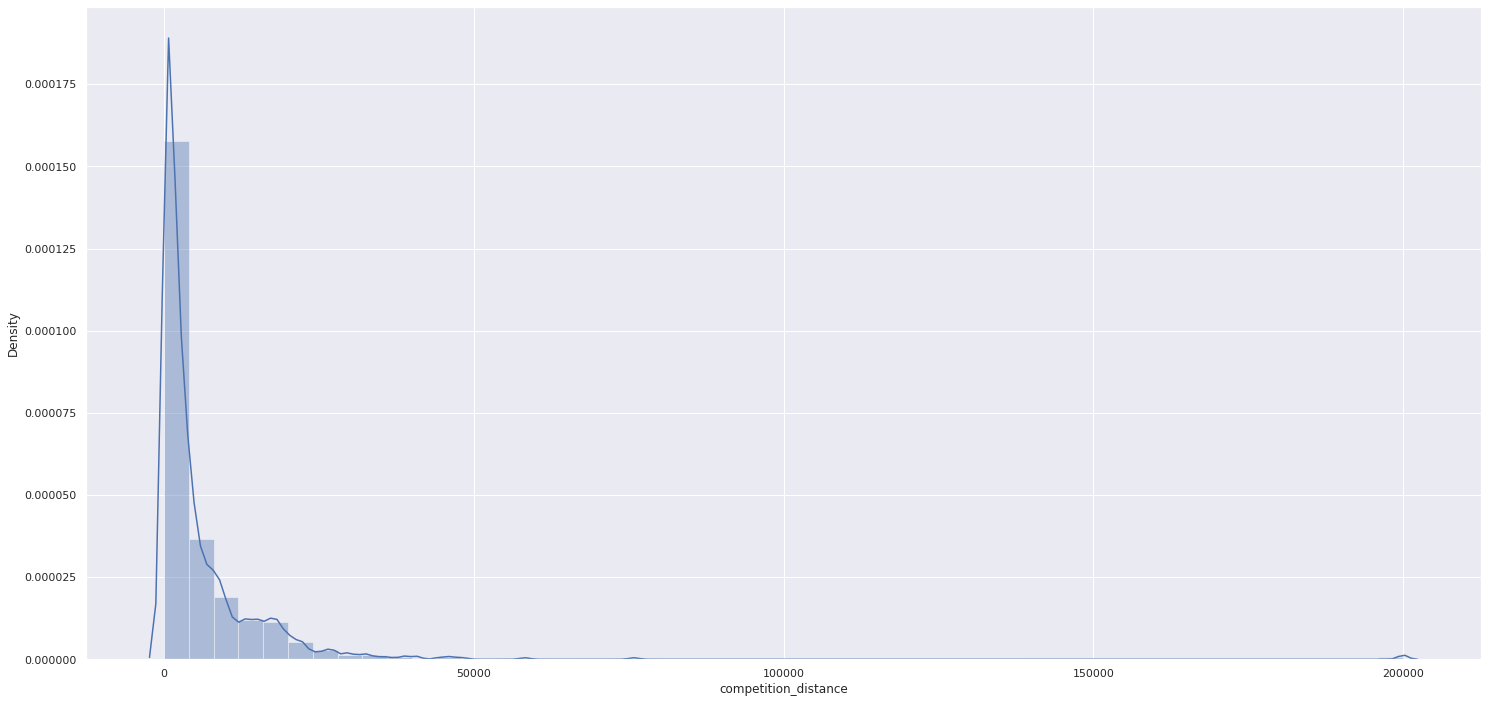

In [34]:
sns.distplot(df1['competition_distance'])

### 1.7.2 Categorical Attributes

In [35]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

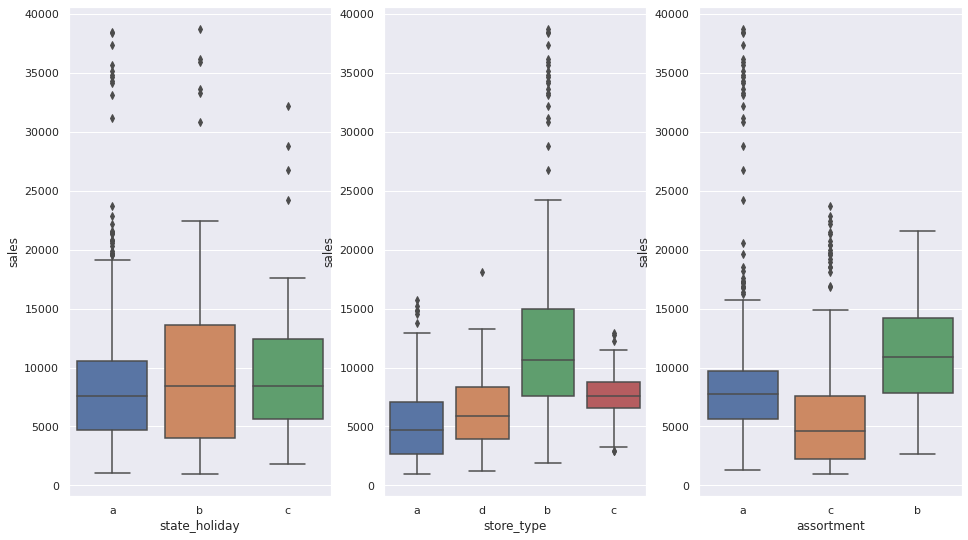

In [36]:
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.figure(figsize=(16, 9))

plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. Passo 02 - Feature Engineering

In [37]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

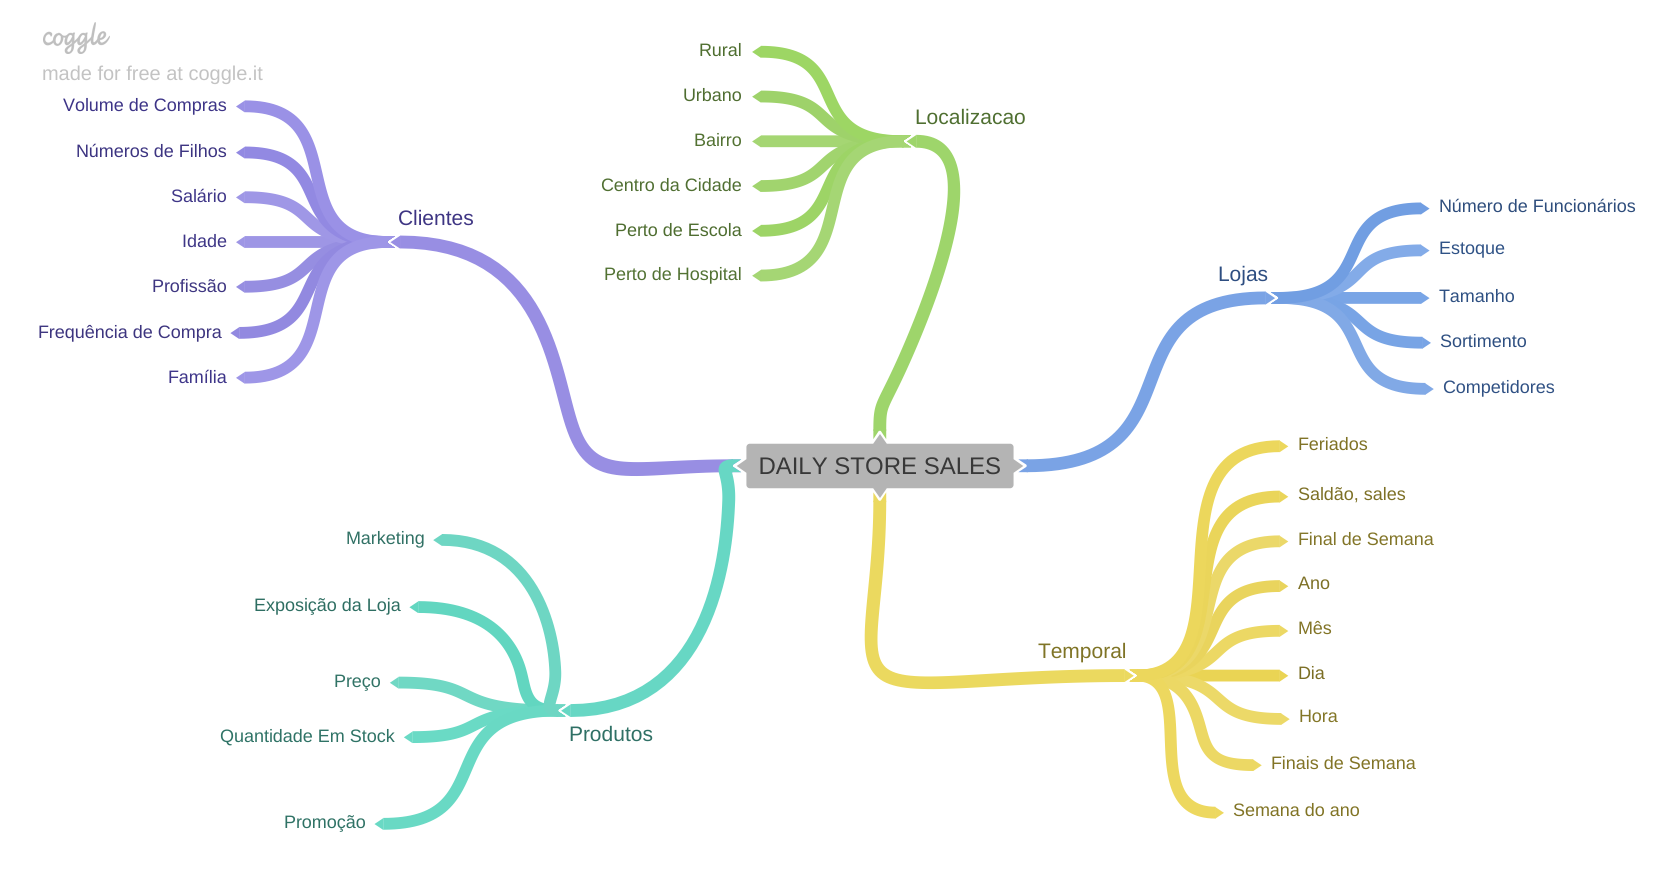

In [38]:
Image('/content/drive/My Drive/Colab Notebooks/data/mindmap.png')

## 2.2. Criação e Lista Final de Hipoteses

### 2.1.1. Hipoteses Loja

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Hipoteses Produto

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Hipoteses Tempo

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

### 2.1.4. Lista Final de Hipoteses

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineering

In [39]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment = using kaggle explanations to correct change column
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday = using kaggle explanations to correct change column
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [40]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. PASSO 03 - Filtragem de Variáveis



In [41]:
df3 = df2.copy()

In [42]:
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1. Filtragem das Linhas

Filtering no open columns because there is no sales on this storages.

In [43]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Selecao das Colunas

Here was filtered some columns:

Customers - because it can't be predicted without another project.

Open - it's no use, because don't have variability.

Promo_interval - it's no use, because others columns supply it.

Month_map = it's no use because others columns supply it.

In [44]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

In [45]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. PASSO 04 - Análise Exploratória de Dados

In [46]:
df4 = df3.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

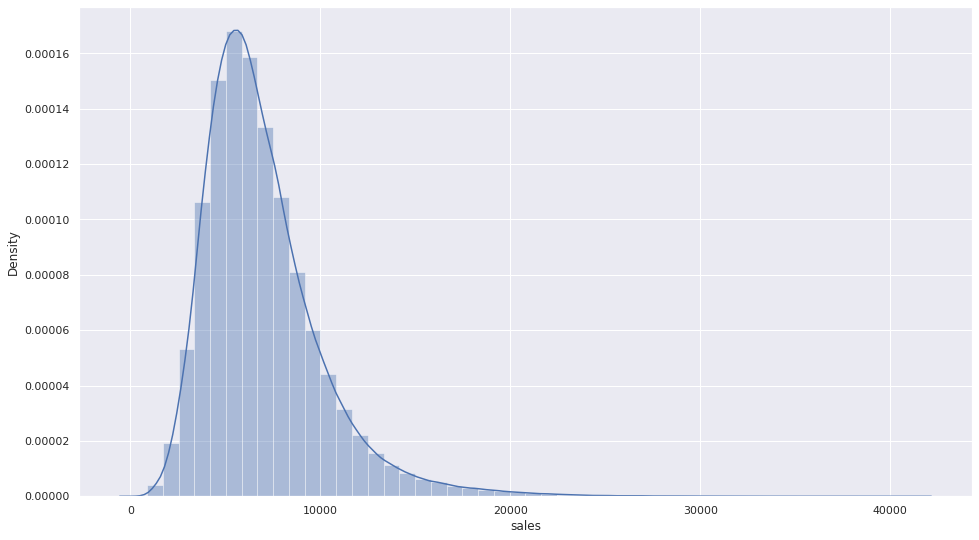

In [47]:
plt.figure(figsize=(16, 9))
sns.distplot(df4['sales'])

### 4.1.2. Numerical Variable

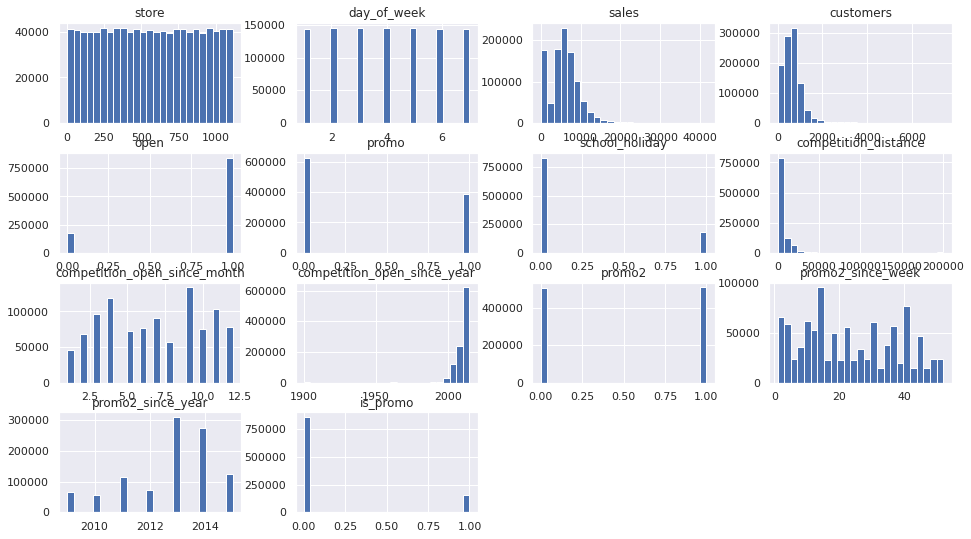

In [48]:
num_attributes.hist(figsize=(16,9), bins=25);

### 4.1.3. Categorical Variable

In [49]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

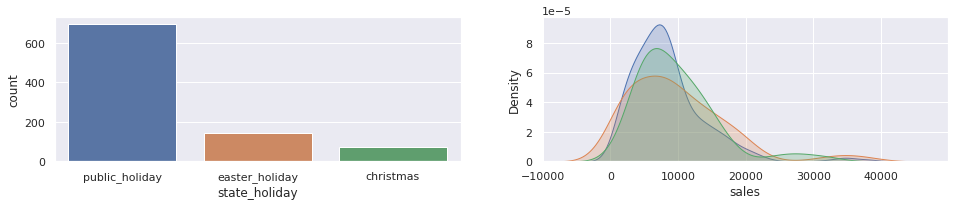

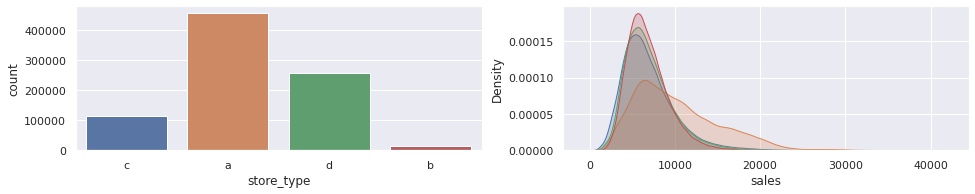

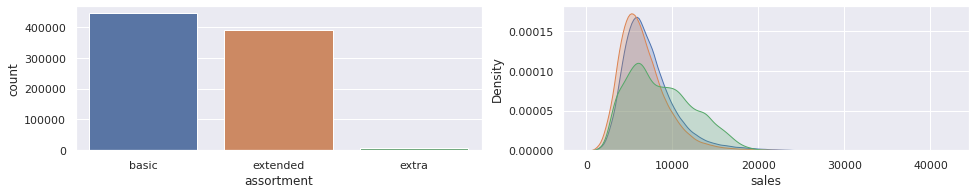

In [50]:
#state_holiday

#fig = plt.figure(figsize=(14,7))
#specs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
#ax1 = fig.add_subplot(specs[0, 0])
#ax2 = fig.add_subplot(specs[0,1])

figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

figura.add_subplot(3, 2, 2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

#store_type
figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 3)
sns.countplot(df4['store_type'])

figura.add_subplot(3, 2, 4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

#assortment
figura = plt.figure(figsize=(16,9))
figura.add_subplot(3, 2, 5)
sns.countplot(df4['assortment'])

figura.add_subplot(3, 2, 6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

## 4.2. Analise Bivariada

### **H1.** Lojas com maior sortimentos deveriam vender mais.
**VERDADEIRO** Lojas com maior sortimento vendem mais

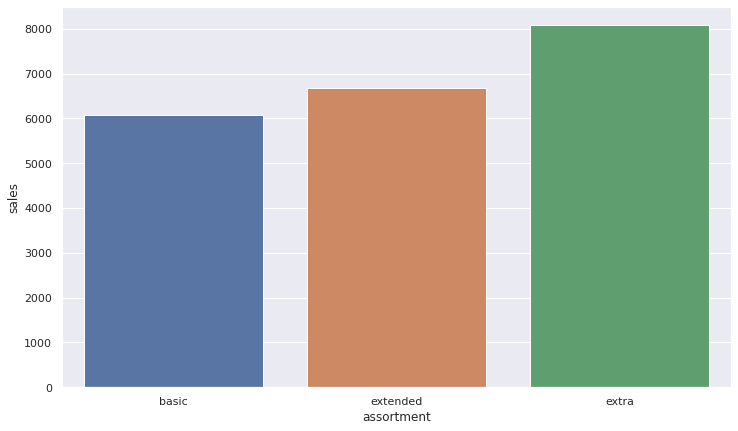

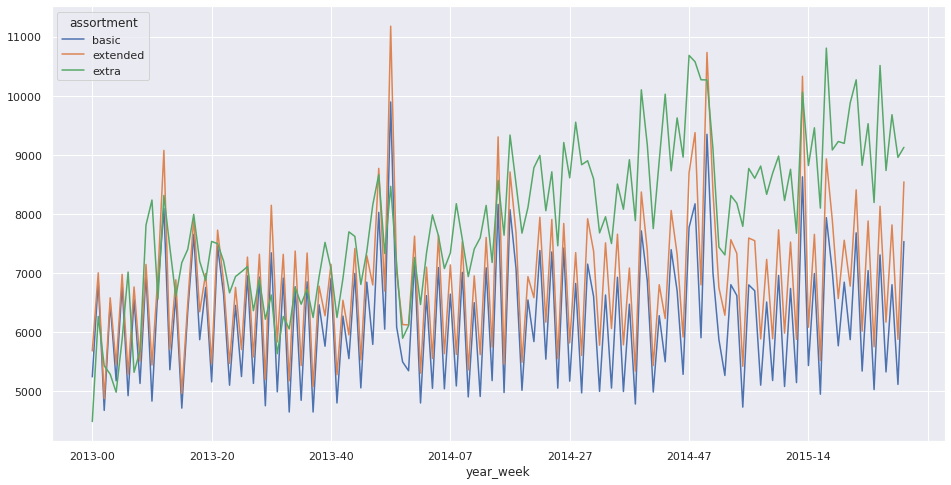

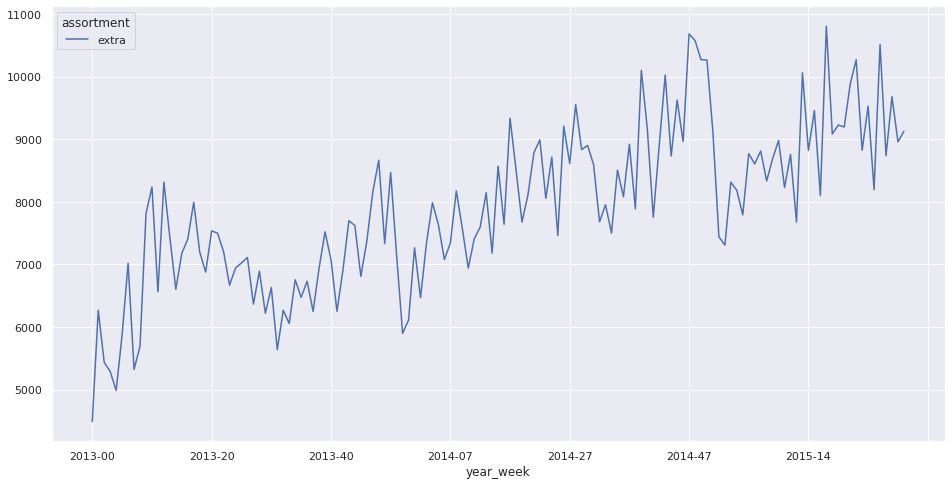

In [51]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').median().reset_index()
plt.figure(figsize=(12,7))
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment']).median().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(16,8))

### **H2.** Lojas com competidores mais próximos deveriam vender menos.
**FALSA** Lojas com competidores mais próximos, vendem aproximadamente o mesmo.

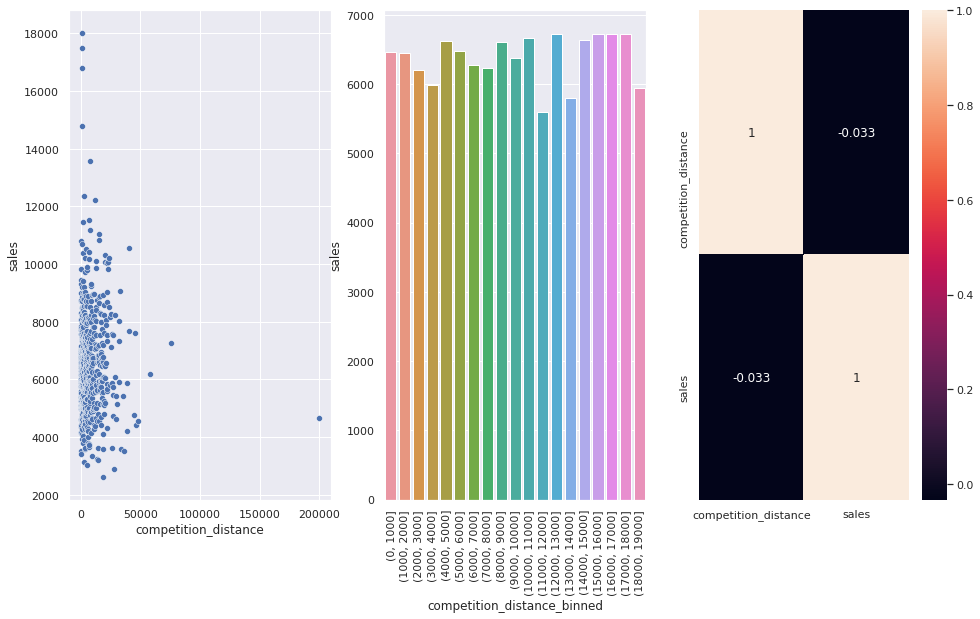

In [52]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()
figura = plt.figure(figsize=(16,9))

figura.add_subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

figura.add_subplot(1, 3, 2)
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').median().reset_index()
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').median().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H3.** Lojas com competidores à mais tempo deveriam vendem mais.
**FALSA** Lojas com competidores a mais tempo vendem MENOS.

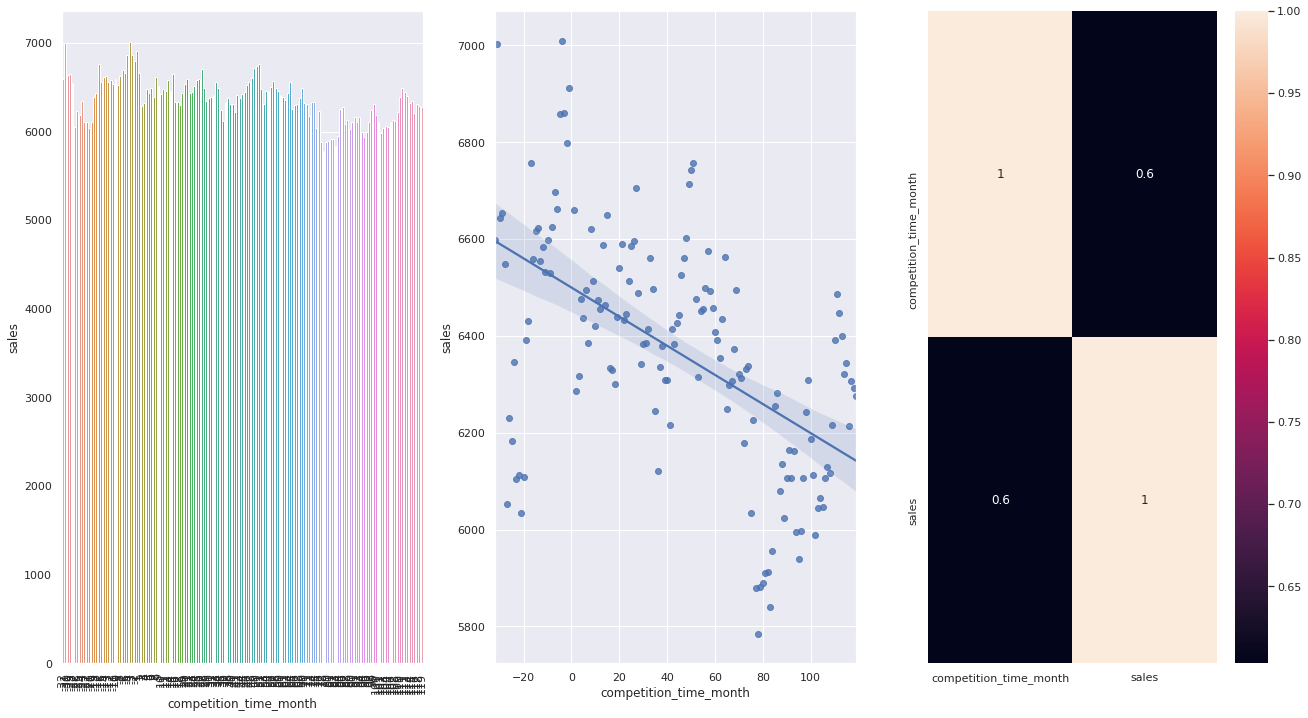

In [53]:
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').median().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]

figura = plt.figure(figsize=(22,12))
figura.add_subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

figura.add_subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

figura.add_subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H4.** Lojas com promoções ativas por mais tempo deveriam vender mais.
**VERDADEIRO** Pois promoções ativas por mais tempo vendem mais.

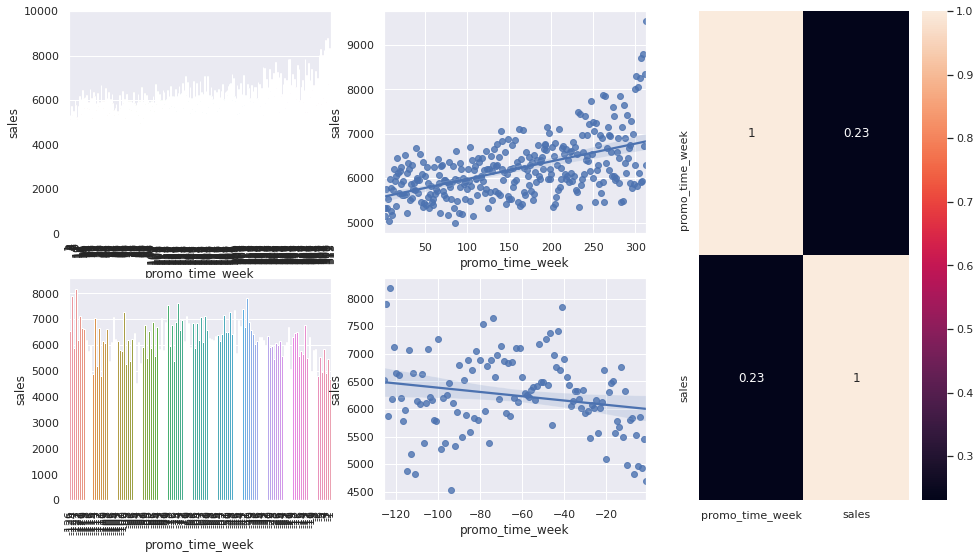

In [54]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').median().reset_index()

grid = gridspec.GridSpec(2, 3)

figura = plt.figure(figsize=(16,9))
#figura.add_subplot(2, 1, 1)
#sns.barplot(x='promo_time_week', y='sales', data=aux1);

figura.add_subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux2);
plt.xticks(rotation=90);

figura.add_subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data=aux2);

figura.add_subplot(grid[1,0])
aux3 = aux1[(aux1['promo_time_week'] < 0)] # promo extendido
sns.barplot(x='promo_time_week', y='sales', data=aux3);
plt.xticks(rotation=90);

figura.add_subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data=aux3);

figura.add_subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> **H5.** Lojas com mais dias de promoção deveriam vender mais.</s>

### **H6.** Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Lojas com mais promoções consecutivas vendem menos

In [55]:
df4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).median().reset_index()

,promo,promo2,sales
0,0,0,5757
1,0,1,5181
2,1,0,7950
3,1,1,7358


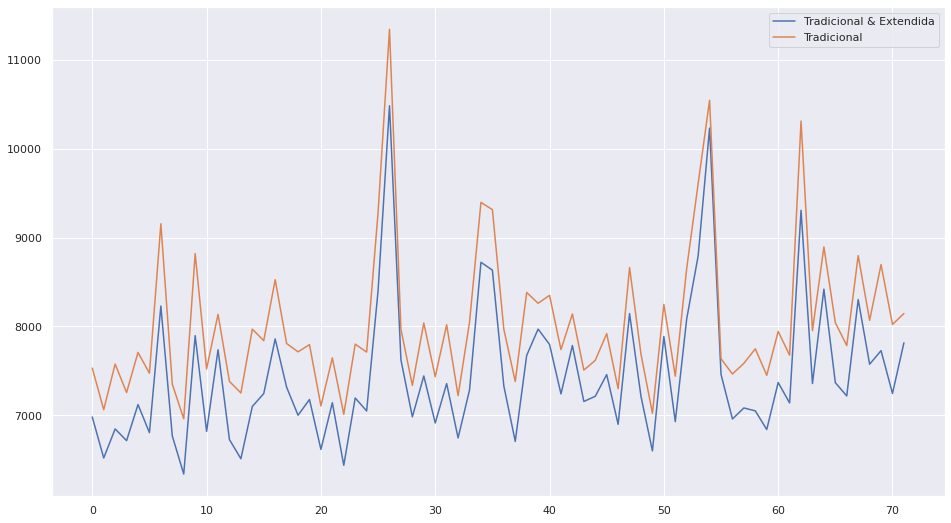

In [56]:
#figura = plt.figure(figsize=(16,9))
#figura.add_subplot(1, 1, 1)

aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').median().reset_index()

ax = aux1.plot(figsize=(16,9));


aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').median().reset_index()
aux2.plot(figsize=(16,9), ax=ax);

ax.legend(labels=['Tradicional & Extendida', 'Tradicional']);

### **H7.** Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas durante o feriado de páscoa vendem mais do que o feriado do natal.

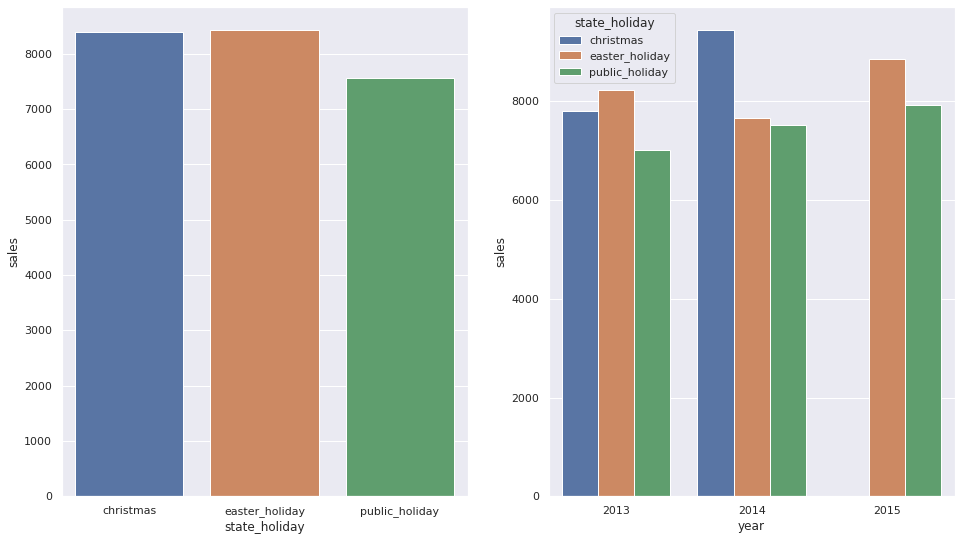

In [57]:
figura = plt.figure(figsize=(16,9))

aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday', 'sales']].groupby('state_holiday').median().reset_index()

figura.add_subplot(1, 2, 1)
sns.barplot(x='state_holiday', y='sales', data=aux1);

aux2 = aux[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).median().reset_index()

figura.add_subplot(1, 2, 2)
sns.barplot(x='year', y='sales', hue='state_holiday', data=aux2);

### **H8.** Lojas deveriam vender mais ao longo dos anos.
**Verdadeiro** Lojas vendem mais ao longo dos anos.

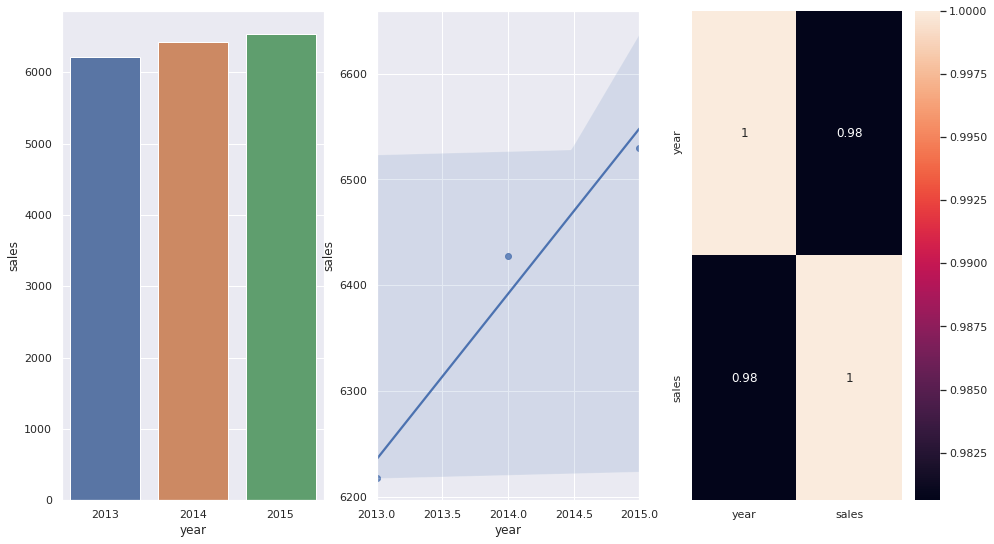

In [58]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['year', 'sales']].groupby('year').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='year', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='year', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H9.** Lojas deveriam vender mais no segundo semestre do ano.
**VERDADEIRA** Lojas vendem mais durante o segundo menestre do ano.

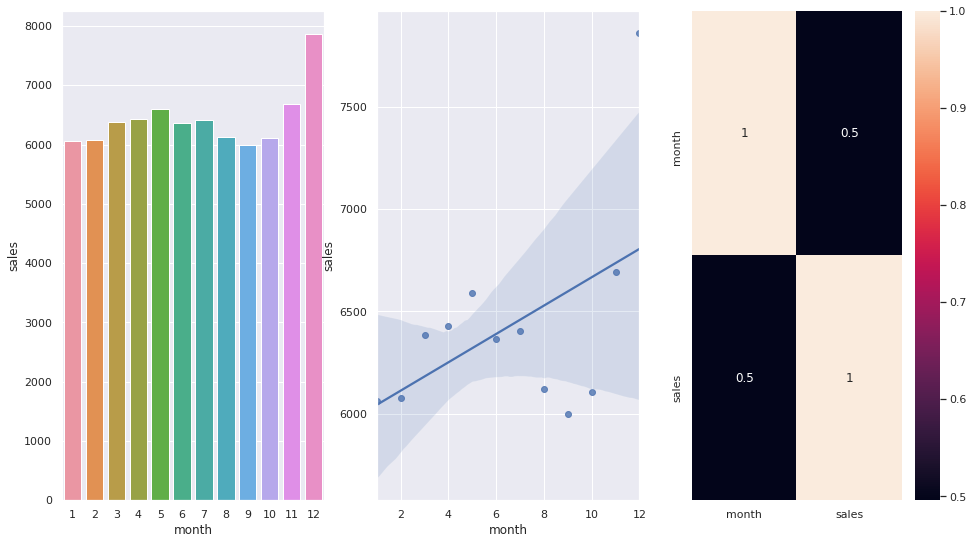

In [59]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['month', 'sales']].groupby('month').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='month', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='month', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **H10.** Lojas deveriam vender mais depois do dia 10 de cada mês.
**FALSA** Lojas vendem menos depois do dia 10 de cada mês.

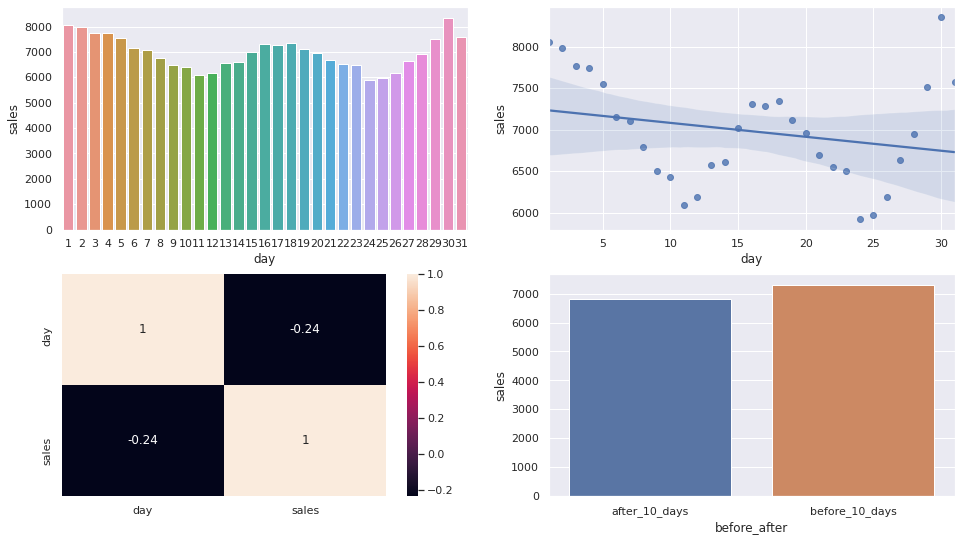

In [60]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['day', 'sales']].groupby('day').mean().reset_index()

figura.add_subplot(2, 2, 1)
sns.barplot(x='day', y='sales', data=aux1);

figura.add_subplot(2, 2, 2)
sns.regplot(x='day', y='sales', data=aux1);

figura.add_subplot(2, 2, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after', 'sales']].groupby('before_after').mean().reset_index()

figura.add_subplot(2, 2, 4)
sns.barplot(x='before_after', y='sales', data=aux2);

### **H11.** Lojas deveriam vender menos aos finais de semana.
**FALSA** Lojas vendem mais no final de semana.

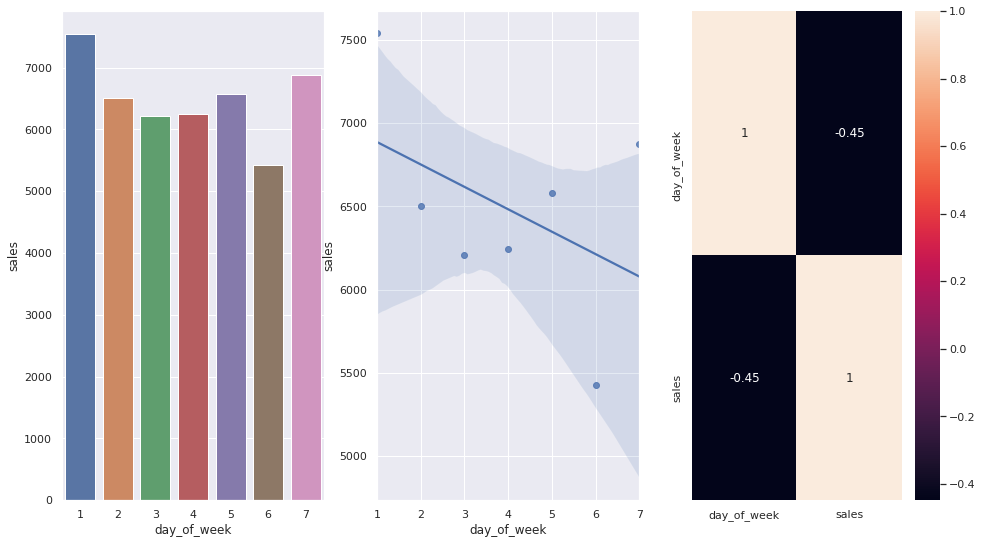

In [61]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['day_of_week', 'sales']].groupby('day_of_week').median().reset_index()

figura.add_subplot(1, 3, 1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

figura.add_subplot(1, 3, 2)
sns.regplot(x='day_of_week', y='sales', data=aux1);

figura.add_subplot(1, 3, 3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### **12.** Lojas deveriam vender menos durante os feriados escolares.
**VERDADEIRA** Lojas abertas durante os feriados escolares, vendem mais.

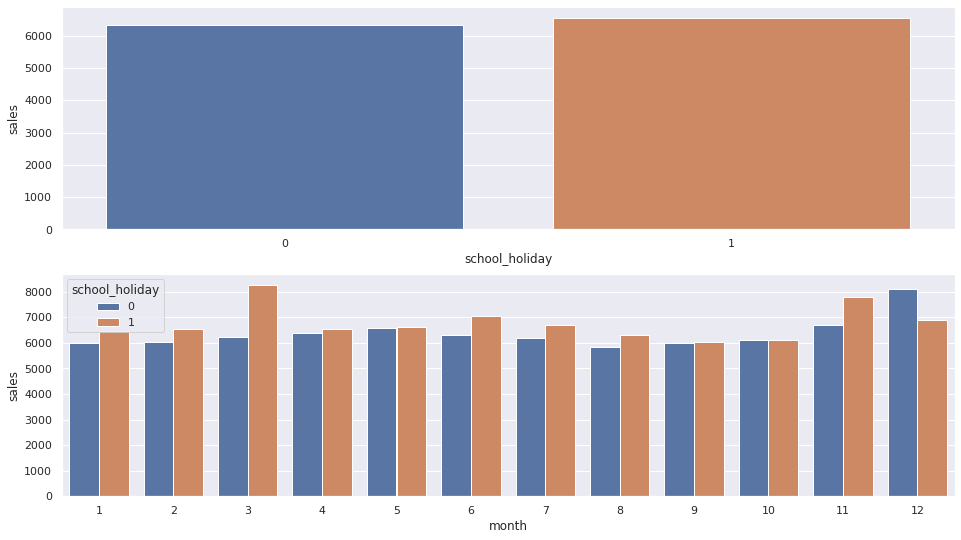

In [62]:
figura = plt.figure(figsize=(16,9))

aux1 = df4[['school_holiday', 'sales']].groupby('school_holiday').median().reset_index()

figura.add_subplot(2, 1, 1)
sns.barplot(x='school_holiday', y='sales', data=aux1);

aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).median().reset_index()

figura.add_subplot(2, 1, 2)
sns.barplot(x='month', y='sales', hue='school_holiday', data=aux2);

### 4.2.1. Resumo das Hipoteses

In [120]:
tab = [['Hipoteses', 'Conclusão', 'Relevância'],
       ['H1', 'Verdadeira', 'Alta'],
       ['H2', 'Falsa', 'Baixa'],
       ['H3', 'Falsa', 'Alta'],
       ['H4', 'Verdadeira', 'Média'],
       ['H5', '-', '-'],
       ['H6', 'Falsa', 'Média'],
       ['H7', 'Falsa', 'Baixa'],
       ['H8', 'Verdadeira', 'Alta'],
       ['H9', 'Verdadeira', 'Alta'],
       ['H10', 'Falsa', 'Média'],
       ['H11', 'Falsa', 'Média'],
       ['H12', 'Verdadeira', 'Baixa']]
print(tabulate(tab, headers='firstrow'))

Hipoteses    Conclusão    Relevância
-----------  -----------  ------------
H1           Verdadeira   Alta
H2           Falsa        Baixa
H3           Falsa        Alta
H4           Verdadeira   Média
H5           -            -
H6           Falsa        Média
H7           Falsa        Baixa
H8           Verdadeira   Alta
H9           Verdadeira   Alta
H10          Falsa        Média
H11          Falsa        Média
H12          Verdadeira   Baixa


## 4.3. Analise Multivariada

### 4.3.1. Numerical Attributes

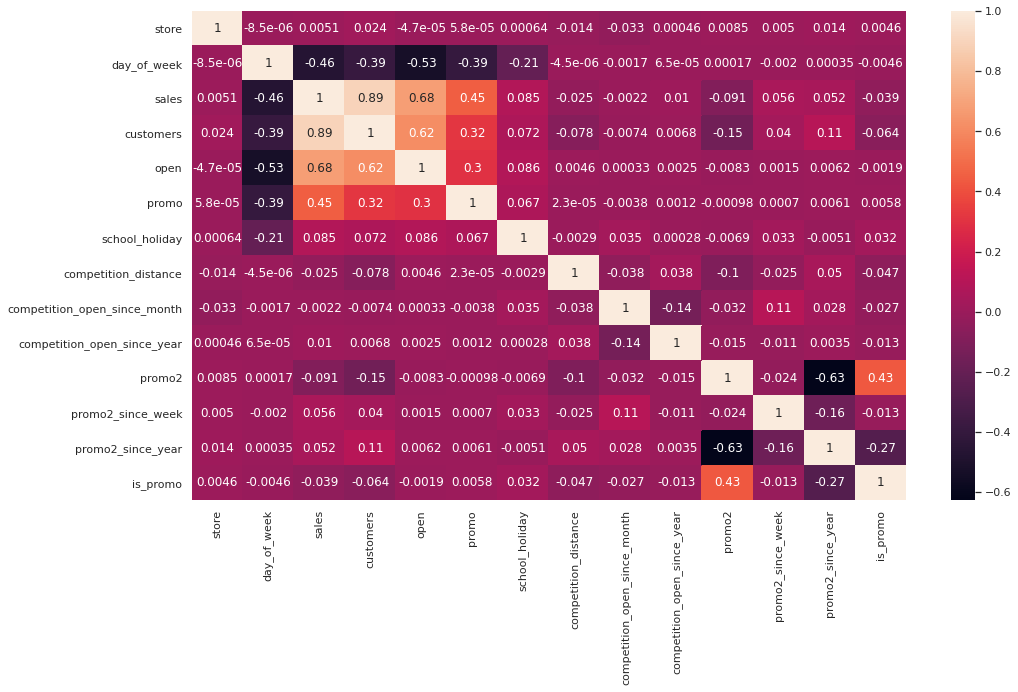

In [66]:
correlation = num_attributes.corr(method='pearson')

# heatmap with all correlations from the numerical attributes
plt.figure(figsize=(16,9))
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Attributes

In [67]:
a = df4.select_dtypes(include='object')

In [68]:
# using cramer v to transform the categorical columns in numerical to calculate the correlation

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

d = pd.DataFrame({'state_holiday':[a1, a2, a3], 
                  'store_type':[a4, a5, a6],
                  'assortment':[a7, a8, a9]})

d = d.set_index(d.columns)

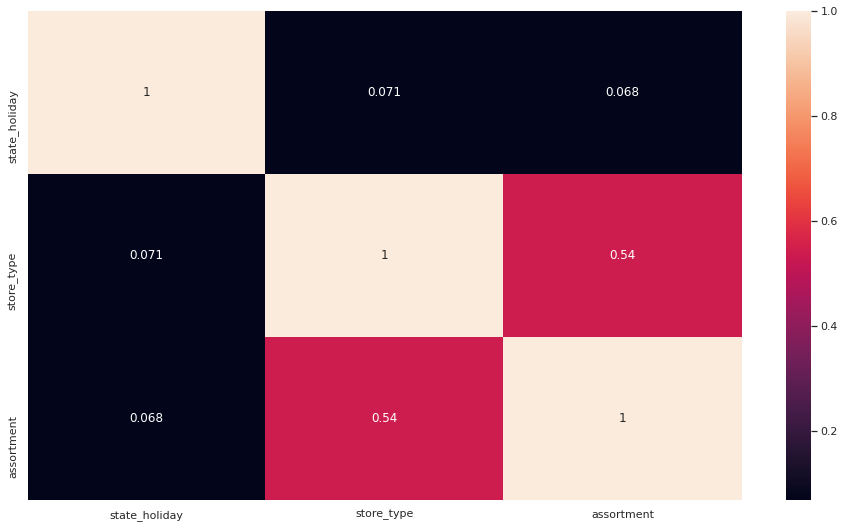

In [69]:
plt.figure(figsize=(16,9))
sns.heatmap(d, annot=True);

# 5.0. PASSO 05 - Data Preparation

In [70]:
df5 = df4.copy()

## 5.1. Normalização (Sem Variáveis)

## 5.2. Rescaling

In [71]:
a = df5.select_dtypes(include=['int64', 'float64'])

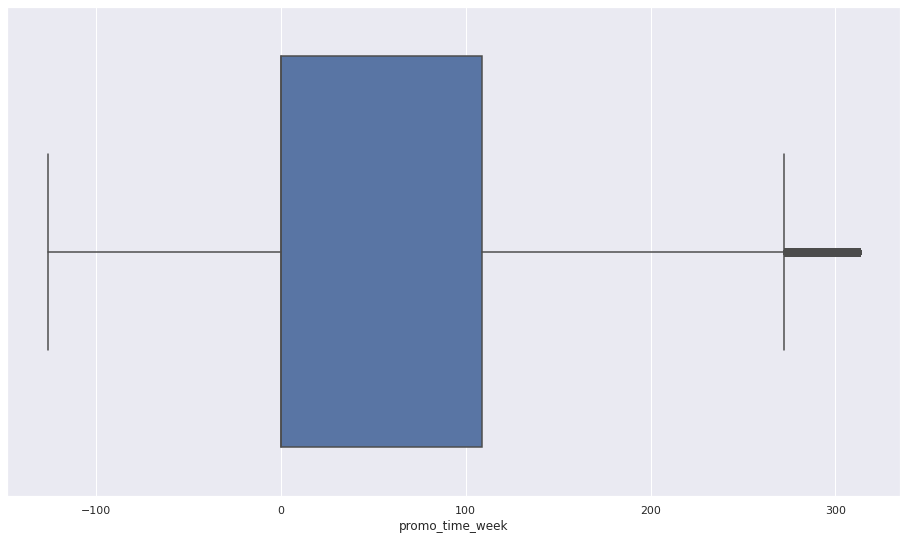

In [72]:
plt.figure(figsize=(16, 9))
sns.boxplot(df5['promo_time_week']);

In [73]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition_distance
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('/content/drive/My Drive/Colab Notebooks/scalers/competition_distance_scaler.pkl', 'wb'))

# competition_time_month
df5['competition_time_month'] = rs.fit_transform( df5[['competition_time_month']].values )
pickle.dump(rs, open('/content/drive/My Drive/Colab Notebooks/scalers/competition_time_month_scaler.pkl', 'wb'))

# promo_time_week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('/content/drive/My Drive/Colab Notebooks/scalers/promo_time_week_scaler.pkl', 'wb'))                              

# year
df5['year'] = mms.fit_transform( df5[['year']].values )   
pickle.dump(mms, open('/content/drive/My Drive/Colab Notebooks/scalers/year_scaler.pkl', 'wb'))                      

## 5.3. Transformation

### 5.3.1. Encoding

In [74]:
# state_holiday = One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [75]:
# store_type = Label Encoding

le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('/content/drive/My Drive/Colab Notebooks/scalers/store_type_scaler.pkl', 'wb'))

In [76]:
# assortment = Ordinal Encoding

assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2. Response Variable Transformation

In [77]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3. Nature Transformation

In [78]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

In [79]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0. PASSO 06 - Feature Selection

In [80]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [81]:
# droping columns that was derivated

cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df6 = df6.drop(cols_drop, axis=1)

In [82]:
#checking the max time

df6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [83]:
# training dataset

X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

# test dataset

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTesting Min Date: {}'.format(X_test['date'].min()))
print('Testing Max Date: {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Testing Min Date: 2015-06-19 00:00:00
Testing Max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [84]:
# training and testing dataset for Boruta

#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [85]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


### 6.2.1. Best Features from Boruta

In [86]:
# showing best features from boruta

#cols_selected = boruta.support_.tolist()

# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

## 6.3. Manual Feature Selection

In [87]:
#saving dataset from boruta

cols_selected_boruta = ['store', 'promo', 'store_type', 'assortment',
                       'competition_distance', 'competition_open_since_month',
                       'competition_open_since_year', 'promo2', 'promo2_since_week',
                       'promo2_since_year', 'competition_time_month', 'promo_time_week',
                       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin',
                       'day_cos', 'week_of_year_sin', 'week_of_year_cos']

# columns to add
feat_to_add = ['date', 'sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

In [88]:
#columns not selected by boruta

cols_not_selected_boruta = ['is_promo',
 'month_sin',
 'school_holiday',
 'state_holiday_christmas',
 'state_holiday_easter_holiday',
 'state_holiday_public_holiday',
 'state_holiday_regular_day',
 'week_of_year_sin',
 'year']

# 7.0. PASSO 07 - Machine Learning Modelling

In [89]:
#training data completed

x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

## 7.1. Average Model

Modeling with the average model

In [90]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store', 'sales']].groupby('store').median().reset_index().rename(columns={'sales':'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1335.706252,0.448645,1872.027111


## 7.2. Linear Regression Model

In [91]:
# model
#lr = LinearRegression().fit(x_train, y_train)

# prediction
#yhat_lr = lr.predict(x_test)

# performance
#lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
#lr_result

### 7.2.1. Linear Regression Model - Cross Validation

In [92]:
#lr = LinearRegression()
#lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)
lr_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3. Linear Regression Regularized Model - Lasso

In [93]:
# model
#lrr = Lasso(alpha=0.001).fit(x_train, y_train)

# prediction
#yhat_lrr = lrr.predict(x_test)

# performance
#lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
#lrr_result

### 7.3.1. Linear Regression Regularized Model (Lasso) - Cross Validation
---



In [94]:
#lrr = Lasso(alpha=0.01)
#lrr_result_cv = cross_validation(x_training, 5, 'Linear Regularized Regression Model (Lasso)', lrr, verbose=False)
lrr_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Linear Regularized Regression Model (Lasso),2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4. Random Forest Regressor

In [95]:
# model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit( x_train, y_train )

# prediction
#yhat_rf = rf.predict(x_test)

# performance
#rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))
#rf_result

### 7.4.1. Random Forest Regressor - Cross Validation

In [96]:
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
#rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67


## 7.5. XGBoost Regressor

In [97]:
# model
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= 100, eta=0.01, 
#                             max_depth=10, subsample=0.7, colsample_bytee=0.9).fit( x_train, y_train )

# prediction
#yhat_xgb = model_xgb.predict(x_test)

# performance
#xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
#xgb_result

### 7.6.1. XGBoost Regressor - Cross Validation 

In [98]:
#model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= 100, eta=0.01, 
#                             max_depth=10, subsample=0.7, colsample_bytee=0.9)
#model_xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
model_xgb_result_cv

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79


## 7.6. Compare Model's Performance

In [99]:
#modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
#modelling_result.sort_values('RMSE')

In [100]:
x_training = X_train[cols_selected_boruta_full]

In [101]:
#model = LinearRegression()
#a = cross_validation(x_training, 5, 'Linear Regression', model, verbose=True)

### 7.7.1. Real Performance - Cross Validation

Here is possible to see the performances of each model.

MAE - the RF Regressor demonstrate the lower MAE that indicate the absolute mean error in value.

MAPE - the MAPE is one percentage from the MAE then the RF Regressor demonstrate the lower too.

RMSE - this metric gives more evidence to outliers because elevate the error in  and the Random Forest Regressor is the best choice here too.

Although, I choiced to continue my work with the XGBoost Regressor because he is just a little less eficienty but much more light.

In [102]:
modelling_result_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, model_xgb_result_cv])
modelling_result_cv.sort_values('RMSE CV')

,Unnamed: 0,Model Name,MAE CV,MAPE CV,RMSE CV
0,0,Random Forest Regressor,838.18 +/- 218.74,0.12 +/- 0.02,1256.87 +/- 319.67
0,0,XGBoost Regressor,1030.28 +/- 167.19,0.14 +/- 0.02,1478.26 +/- 229.79
0,0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37
0,0,Linear Regularized Regression Model (Lasso),2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


# 8.0. PASSO 08 - Hyperparameter Fine Tuning

## 8.1. Random Search

In [103]:
#param = {'n_estimators':[1500, 1700, 2500, 3000, 3500],
#         'eta':[0.01, 0.03],
#         'max_depth':[3, 5, 9],
#         'subsample':[0.1, 0.5, 0.7],
#         'colsample_bytee':[0.3, 0.7, 0.9],
#         'min_child_weight':[3, 8, 15]}

#MAX_EVAL = 2

In [104]:
#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
  # choose values for parameters randomly
#  hp = {k:random.sample(v, 1)[0] for k, v in param.items()}
#  print(hp)

  # model
#  model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= hp['n_estimators'], eta=hp['eta'], 
#                              max_depth=hp['max_depth'], subsample=hp['subsample'], colsample_bytee=hp['colsample_bytee'],
#                              min_child_weight=hp['min_child_weight'])

  # performance
#  result = cross_validation(x_training, 3, 'XGBoost Regressor', model_xgb, verbose=False)
#  final_result = pd.concat([final_result, result])

#print(final_result)
#final_result.to_csv('/content/drive/My Drive/Colab Notebooks/results/final_result_xgb_cv.csv')

## 8.2. Final Model Search

Was used the random search method to seek the best parameters and below is the best results.

In [105]:
param_tuned = {'n_estimators': 3000,
         'eta': 0.03,
         'max_depth': 5,
         'subsample': 0.7,
         'colsample_bytee': 0.7,
         'min_child_weight': 3}

In [106]:
# model
#model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror', n_estimators= param_tuned['n_estimators'], eta=param_tuned['eta'], 
#                               max_depth=param_tuned['max_depth'], subsample=param_tuned['subsample'], colsample_bytee=param_tuned['colsample_bytee'],
#                               min_child_weight=param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
#yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
#xgb_result_tuned = ml_error('XGBoost Regressor Tuned', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor Tuned,664.974997,0.097529,957.774225


In [107]:
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(yhat_xgb_tuned))

# 9.0. PASSO 09 - Tradução e Interpretação do Erro

In [108]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business Performance

Here was made the analysis of the scenarios in the errors of the model.

In [109]:
# sum of predictions
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# Scenarios
df92['worst_scenario'] = df92['predictions'] - (df92['MAPE']*df92['predictions'])
df92['best_scenario'] = df92['predictions'] + (df92['MAPE']*df92['predictions'])

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [110]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,104033.085938,45168.242739,162897.929136,3318.104402,0.565828
908,909,238233.875000,114249.019227,362218.730773,7660.537746,0.520433
875,876,203030.156250,141085.778935,264974.533565,3919.203836,0.305099
721,722,353005.781250,258280.807271,447730.755229,1992.156131,0.268338
594,595,400883.625000,303792.971218,497974.278782,3468.361830,0.242192


In [111]:
df92['predictions'][291] - df92['worst_scenario'][291]

58864.84319803374

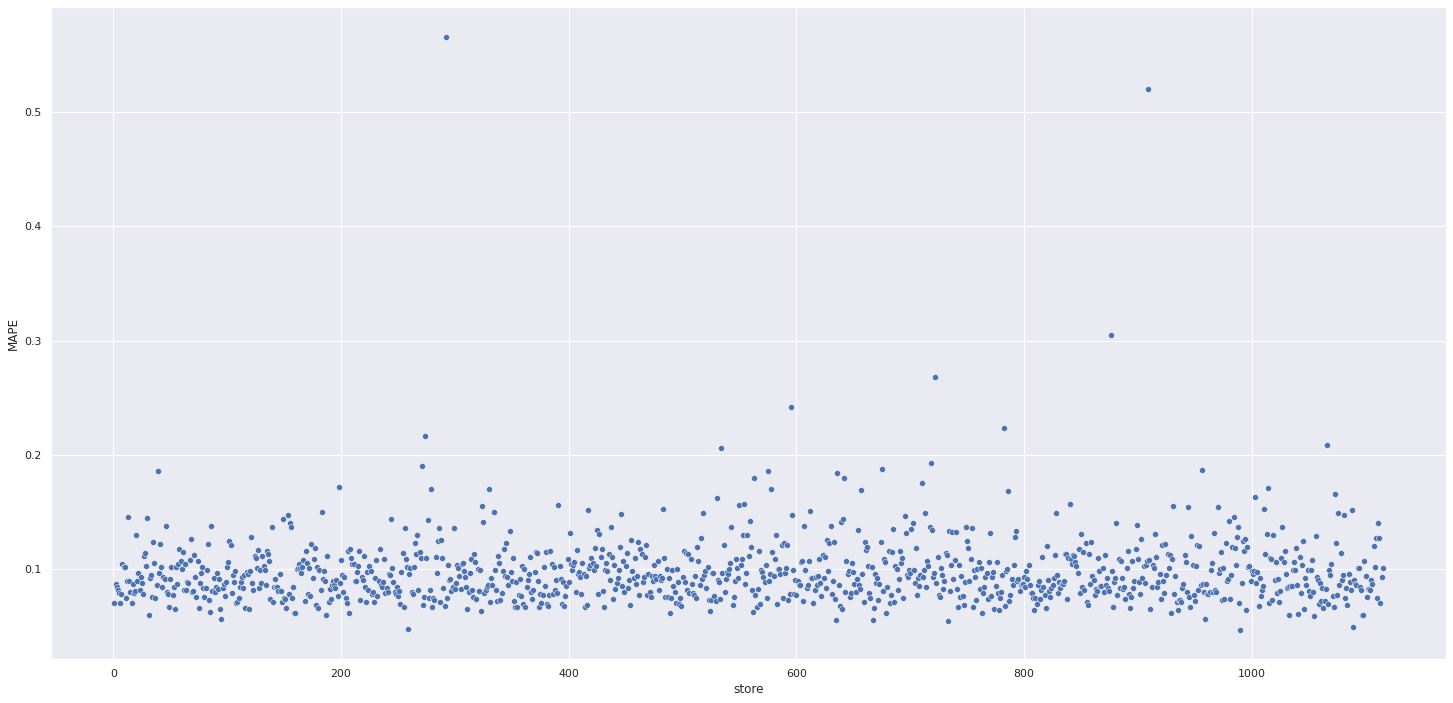

In [112]:
sns.scatterplot(x='store', y='MAPE', data=df92);

## 9.2. Total Performance

Here I decided to translate the informations in job informations to be understandable to people from the business area.

In [113]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenario', 0:'Values'})
df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$285,860,480.00"
1,worst_scenario,"R$258,289,614.55"
2,best_scenario,"R$313,431,381.14"


## 9.3. Machine Learning Performance

On the end, was made a model performance analysis

In [114]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions']/df9['sales']

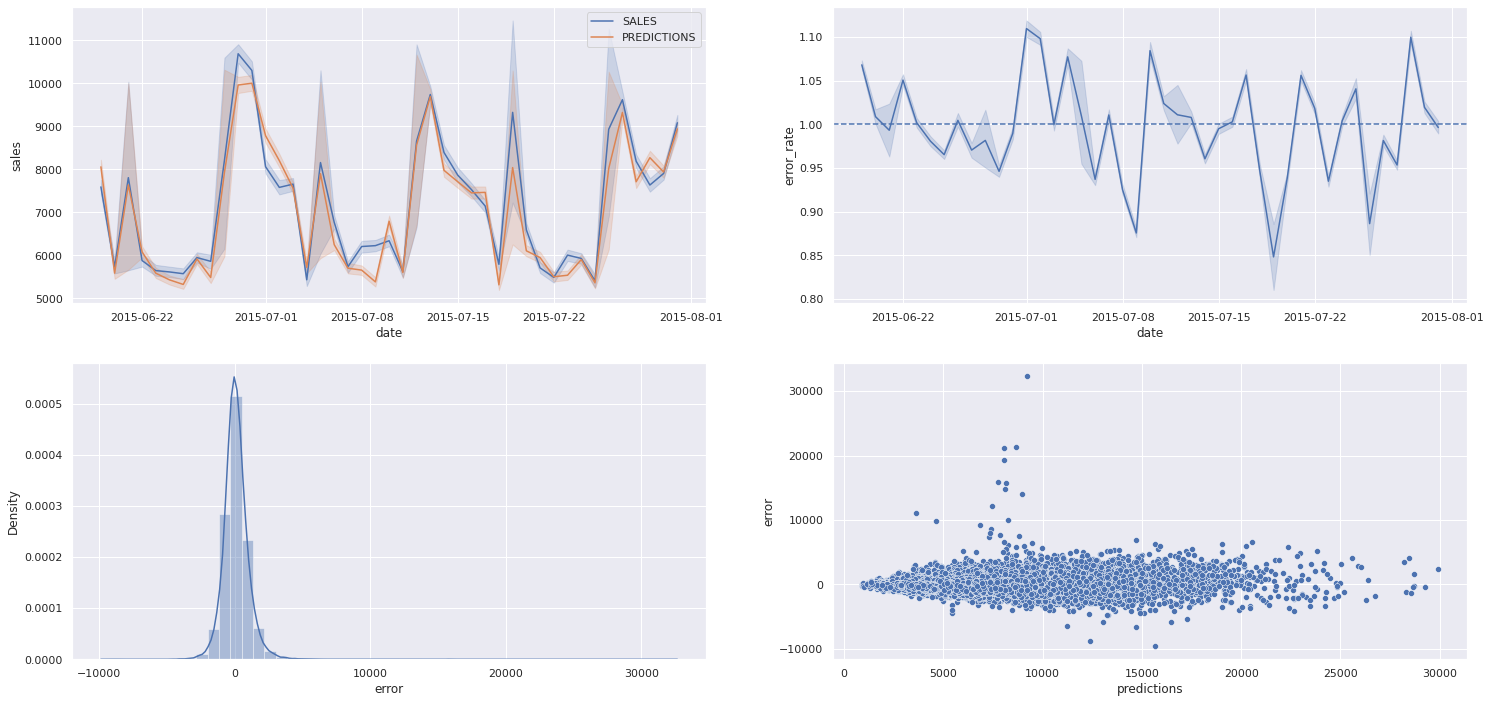

In [115]:
plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline( 1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df9['error'])

plt.subplot(2, 2, 4)
sns.scatterplot(df9['predictions'], df9['error'])

# 10. PASSO 10 - Deploy Model to Production

Here has a sketch to pass to a .py archive before and make the deploy of this model.

In [116]:
# Save Trained Model

#pickle.dump(model_xgb_tuned, open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'wb'))
#pickle.dump(yhat_xgb_tuned, open('/content/drive/My Drive/Colab Notebooks/results/yhat_xgb_tuned.pkl', 'wb'))
#pickle.dump(xgb_result_tuned, open('/content/drive/My Drive/Colab Notebooks/results/xgb_result_tuned.pkl', 'wb'))

## 10.1. Rossmann Class

In [117]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime

class Rossmann(object):

  def _init_(self):

    self.home_path = '/content/drive/My Drive/Colab Notebooks/'

    self.competition_distance_scaler = pickle.load(open( self.home_path + 'scalers/competition_distance_scaler.pkl', 'rb'))
 
    self.competition_time_month_scaler = pickle.load(open(self.home_path + 'scalers/competition_time_month_scaler.pkl', 'rb'))
   
    self.promo_time_week_scaler = pickle.load(open(self.home_path + 'scalers/promo_time_week_scaler.pkl', 'rb'))
   
    self.year_scaler = pickle.load(open(self.home_path + 'scalers/year_scaler.pkl', 'rb'))
   
    self.store_type_scaler = pickle.load(open(self.home_path + 'scalers/store_type_scaler.pkl', 'rb'))

  def data_cleaning(self, df1):

    ## 1.1. Rename Columns

    cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
          'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
          'CompetitionDistance', 'CompetitionOpenSinceMonth',
          'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
          'Promo2SinceYear', 'PromoInterval']

    snakecase = lambda x: inflection.underscore( x )

    cols_new = list(map( snakecase, cols_old))

    # rename
    df1.columns = cols_new

    ## 1.3. Data Types

    df1['date'] = pd.to_datetime(df1['date'])

    ## 1.5. Fillout NA

    #competition_distance  

    df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 
                                      if math.isnan(x) else x)

    #competition_open_since_month

    df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) 
                                                    else x['competition_open_since_month'], axis=1)


    #competition_open_since_year
    df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) 
                                                  else x['competition_open_since_year'], axis=1)

                                  
    #promo2_since_week
    df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) 
                                        else x['promo2_since_week'], axis=1)

    #promo2_since_year   
    df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) 
                                        else x['promo2_since_year'], axis=1)

    #promo_interval
    month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

    df1['promo_interval'].fillna(0, inplace=True)

    df1['month_map'] = df1['date'].dt.month.map(month_map)

    df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 
                                                    if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

    ## 1.6. Change Types
    df1.dtypes
    df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
    df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

    df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
    df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

    return df1

  def feature_engineering(self, df2):

    ## 2.3. Feature Engineering
    
    # year
    df2['year'] = df2['date'].dt.year

    # month
    df2['month'] = df2['date'].dt.month

    # day
    df2['day'] = df2['date'].dt.day

    # week of year
    df2['week_of_year'] = df2['date'].dt.isocalendar().week

    # year week
    df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

    # competition since
    df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
    df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

    # promo since
    df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
    df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
    df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

    # assortment
    df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')


    # state holiday
    df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

    # 3.0. PASSO 03 - FILTRAGEM DE VARIÁVEIS

    ## 3.1. Filtragem das Linhas

    df2 = df2[(df3['open'] != 0)]

    ## 3.2. Selecao das Colunas

    cols_drop = ['open', 'promo_interval', 'month_map']
    df2 = df2.drop(cols_drop, axis=1)
    
    return df2

  def data_preparation(self, df5, ft):

    ## 5.2. Rescaling
    # competition_distance
    df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

    # competition_time_month
    df5['competition_time_month'] = self.competition_time_month_scaler.fit_transform( df5[['competition_time_month']].values )
    
    # promo_time_week
    df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )                              

    # year
    df5['year'] = self.year_scaler.fit_transform( df5[['year']].values ) 

    ## 5.3. Transformation

    ### 5.3.1. Encoding

    # state_holiday = One Hot Encoding

    df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

    # store_type = Label Encoding

    df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])
    
    # assortment = Ordinal Encoding

    assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
    df5['assortment'] = df5['assortment'].map(assortment_dict)

    ### 5.3.3. Nature Transformation

    # day_of_week
    df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x*(2.*np.pi/7)))
    df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x*(2.*np.pi/7)))

    # month
    df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x*(2.*np.pi/12)))
    df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x*(2.*np.pi/12)))

    # day
    df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x*(2.*np.pi/30)))
    df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x*(2.*np.pi/30)))

    # week_of_year
    df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x*(2.*np.pi/52)))
    df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x*(2.*np.pi/52)))

    cols_selected = ['store', 'promo', 'store_type', 'assortment',
                       'competition_distance', 'competition_open_since_month',
                       'competition_open_since_year', 'promo2', 'promo2_since_week',
                       'promo2_since_year', 'competition_time_month', 'promo_time_week',
                       'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_sin',
                       'day_cos', 'week_of_year_sin', 'week_of_year_cos']

    return df5[cols_selected]

  def get_prediction(self, model, original_data, test_data):
    
    # prediction
    pred = model.predict(test_data)

    # join pred into the original data
    original_data['prediction'] = np.expm1(pred)

    return original_data.to_json(orient='records', date_format='iso')

## 10.2. API Handler

In [118]:
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann
import pandas as pd
import pickle
import xgboost as xgb

# loading model
model = pickle.load(open('/home/valcilio/PycharmProjects/Rossmann Sales Predict/results/yhat_xgb_tuned.pkl', 'rb'))

# initializa API
app = Flask(__name__)

@app.route('/rossmann/project')
def rossmann_predict():
    test_json = request.get_json()

    if test_json:  # there is data
        if isinstance(test_json, dict):  # unique example
            test_raw = pd.DataFrame(test_json, index=[0])

        else:  # Multiple Examples
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossman Class
        pipeline = Rossmann()

        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df2 = pipeline.feature_engineering(df1)

        # data preparation
        df3 = pipeline.data_preparation(df2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)

        return df_response

    else:
        return Response('200', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run(debug=True)

ModuleNotFoundError: ignored

## 10.3. API Tester

In [ ]:
df10 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/test.csv')

In [ ]:
# merge test dataset + store
df_test = pd.merge( df10, df_store_raw, how='left', on='Store' )

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 23, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop( 'Id', axis=1 )

In [ ]:
# convert Dataframe to json
data = json.dumps( df_test.to_dict( orient='records' ) )

In [ ]:
# API Call
url = 'http://0.0.0.0:5000/rossmann/predict'
#url = 'https://rossmann-model-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json' } 
data = data

r = requests.post( url, data=data, headers=header )
print( 'Status Code {}'.format( r.status_code ) )

In [ ]:
model_xgb_tuned.save_model('/content/drive/My Drive/Colab Notebooks/data/model_xgb.json')

In [ ]:
model_xgb_tuned = pickle.load(open('/content/drive/My Drive/Colab Notebooks/results/model_xgb_tuned.pkl', 'rb'))

In [ ]:
model_xgb_tuned